# Monthly mean temperatures

In [1]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# Python
import pandas as pd
import numpy as np
import datetime
from prophet import Prophet
from math import sqrt

#
from warnings import catch_warnings
from warnings import filterwarnings

# La librería statsmodel tiene implementaciones de SARIMA y de Holt-Winters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Si el computador tiene procesadores múltiples, se aprovecharán
#from multiprocessing import cpu_count

from multiprocess import cpu_count
from joblib import Parallel

from joblib import delayed

In [3]:
def parse_date (x): 
    return datetime.datetime.strptime("0"+str(x), '%y-%m') 

In [4]:
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

In [5]:
def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

In [48]:
def busqueda_malla(datos, lista_cfg, n_prueba, metodo = "sarima", paralelo = True):
    resultados = None
    if paralelo:
        # ejecutar las configuraciones en paralelo
        executor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing') 
        tareas = (delayed(calificar_modelo)(datos, n_prueba, metodo, cfg) for cfg in lista_cfg)
        resultados = executor(tareas)

    else:
        resultados = [calificar_modelo(datos, n_prueba, metodo, cfg) for cfg in lista_cfg]
    # eliminar resultados vacíos
    resultados = [r for r in resultados if r[1] != None]
    return resultados

In [47]:
def calificar_modelo(datos, n_prueba, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir la confiuración a una llave
    llave = str(cfg)
    if debug:
        resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
    else:
        # una falla durante la validación del modelo sugiere una configuración inestable
        try:
        # nunca mostrar advertencias cuando se busca en malla...demasiado "ruido"
            with catch_warnings():
                filterwarnings("ignore")
                resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
                print('aaaaa resul', resultado, predicciones)
        except:
            error = None
            print('Error None')
    print('aaaaaaa', resultado)
    if resultado is not None:
        print(f' > Modelo{llave} {resultado:.3f}')
    return (llave, resultado, predicciones)

In [8]:
def config_simple(long_max, offsets = [1]):
    configs = []
    print('long max: ', long_max)
    for i in range(1, long_max + 1):
        for t in ['mediana',"promedio"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# prediccion de un paso por promedio
def prediccion_promedio(historia, config):
    n, tipo_promedio = config
    if tipo_promedio == 'promedio':
        return mean(historia[-n:])
    return median(historia[-n:])

In [9]:
def prediccion_prophet(series):
    series.head()
    modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);
    futuro = modelo.make_future_dataframe(periods = 1,freq = 'M')
    predicciones = modelo.predict(futuro)
    return predicciones.iloc[-1]["yhat"]

In [10]:
def evaluar_modelo(datos, n_entreno, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir config a una llave
    llave = str(cfg)
    resultado, predicciones = validacion_al_frente(datos, n_entreno, metodo, cfg)
    if resultado is not None:
        print(f' > Modelo[{llave}] {resultado:.3f}')
    return (llave, resultado, predicciones)

In [11]:
# validación "walk-forward" para datos univariados
def validacion_al_frente(datos, n_prueba, metodo, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        if metodo == "promedio":
            yhat = prediccion_promedio(historia, cfg)
        elif metodo == "sarima":
            yhat = prediccion_sarima(historia, cfg)
        elif metodo == "exp":
            yhat = prediccion_alisamiento_exp(historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    return [error, predicciones]

In [49]:
def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    paralelo = False
    # dividir los datos
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos
    if metodo == "sarima":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_sarima()
        paralelo = False

    elif metodo == "promedio":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_simple(long_max)
        
    elif metodo == "exp":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_alisamiento_exp()
        datos = datos[:,0]
        paralelo = False

    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        print('if, lista_cfg', lista_cfg_azar)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo, paralelo)
    else:
        # búsqueda en malla
        print('else, datos, lista_cfg, n_prueba, metodo')
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo, paralelo)
        
    
    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])


    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .8, figsize = (14,7))
    # Esconder las líneas de malla de la gráfica
    # ax.grid(False)

    # Esconder las marcas en los ejes
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()

In [13]:
def buscar_mejor_solucion(series, nombre, metodo = "prophet"):    
    datos = series

    resultados = []
    # división de datos
    n_entreno = int(len(datos)*0.8) # porcentaje usado para entrenar
    long_max = len(datos) - n_entreno
    print(f"Tamaño entreno {n_entreno} ")
    print(f"Tamaño prueba {long_max}")
    lista_cfg = [1]
    
    resultados = [evaluar_modelo(datos, n_entreno, metodo, cfg) for cfg in lista_cfg]
    
    # ordenar configs por error, ascendente
    resultados.sort(key=lambda tup: tup[1])


    print('terminado')
    # listar las tres configuraciones mejores
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    
    #desplegar
    entreno, prueba = division_entreno_prueba(datos,n_entreno)
    prediccion = pd.DataFrame(list(entreno["y"]) + resultados[0][2])
    
    #####
    datos.set_index(['ds'],inplace=True)
    #prediccion.set_index(['ds'],inplace = True)
    prediccion.index = datos.index


    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig(f"{nombre}_{metodo}.png")
    plt.show()
    return [datos,prediccion]

In [14]:
def evaluar_prediccion(series, frecuencia = "M"):
    datos = series
    n_entreno = int(len(datos) * 0.8) # porcentaje usado para entreno
    long_max = len(datos) - n_entreno
    print(f"Tamaño entreno {n_entreno} ")
    print(f"Tamaño prueba {long_max} ")
    lista_cfg = [1]
    entreno, prueba = division_entreno_prueba(datos, n_entreno)
    modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);
    futuro = modelo.make_future_dataframe(periods = len(prueba),freq = frecuencia)
    predicciones = modelo.predict(futuro)
    modelo.plot(predicciones)
    rmse = medir_rmse(predicciones.iloc[len(entreno):len(series)]["yhat"], prueba["y"])
    print(f"RMSE: {rmse}")

## 1. Análisis exploratorio

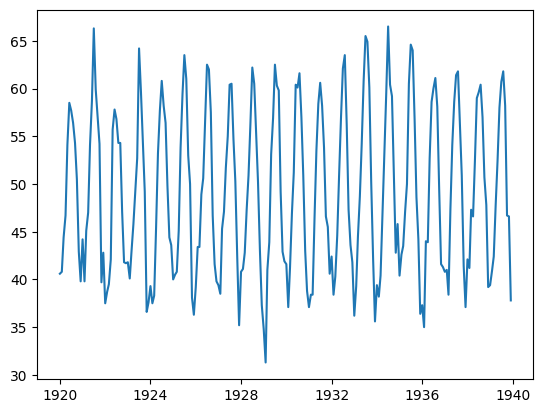

In [15]:
series = pd.read_csv('monthly-mean-temp.csv', header=0, index_col=None)
series['ds']  = pd.to_datetime(series['Month'])
series[['y']] = series[['Temperature']].astype(float)
series = series[["ds","y"]]
#evaluar_prediccion(series)
plt.plot(series['ds'], series['y'])

#### Este set de datos presenta una tendencia de ser estacional. Esto tiene sentido, ya que se estan midiendo temperaturas a lo largo del año y debido a las diferentes estaciones que hay durante un año. Se tendría que saber de que país o que lugar de la tierra fueron recabados los datos para saber si las estaciones son marcadas por la temperatura como se puede mostrar en la gráfica.

## 2. Promedios

Tamaño Entrenamiento 192
Tamaño Prueba 48
Encontrando la mejor solución para promedio
long max:  192
termino
else, datos, lista_cfg, n_prueba, metodo
 > Modelo[1, 'promedio'] 5.144
 > Modelo[2, 'promedio'] 6.595
 > Modelo[3, 'promedio'] 8.144
 > Modelo[4, 'promedio'] 9.405
 > Modelo[5, 'promedio'] 10.343
 > Modelo[6, 'promedio'] 10.946
 > Modelo[7, 'promedio'] 11.168
 > Modelo[8, 'promedio'] 11.018
 > Modelo[9, 'promedio'] 10.560
 > Modelo[10, 'promedio'] 9.887
 > Modelo[11, 'promedio'] 9.113
 > Modelo[12, 'promedio'] 8.384
 > Modelo[13, 'promedio'] 7.861
 > Modelo[14, 'promedio'] 7.655
 > Modelo[15, 'promedio'] 7.770
 > Modelo[16, 'promedio'] 8.130
 > Modelo[17, 'promedio'] 8.566
 > Modelo[18, 'promedio'] 8.977
 > Modelo[19, 'promedio'] 9.272
 > Modelo[20, 'promedio'] 9.388
 > Modelo[21, 'promedio'] 9.321
 > Modelo[22, 'promedio'] 9.074
 > Modelo[23, 'promedio'] 8.726
 > Modelo[24, 'promedio'] 8.354
 > Modelo[25, 'promedio'] 8.062
 > Modelo[26, 'promedio'] 7.923
 > Modelo[27, 'promedi

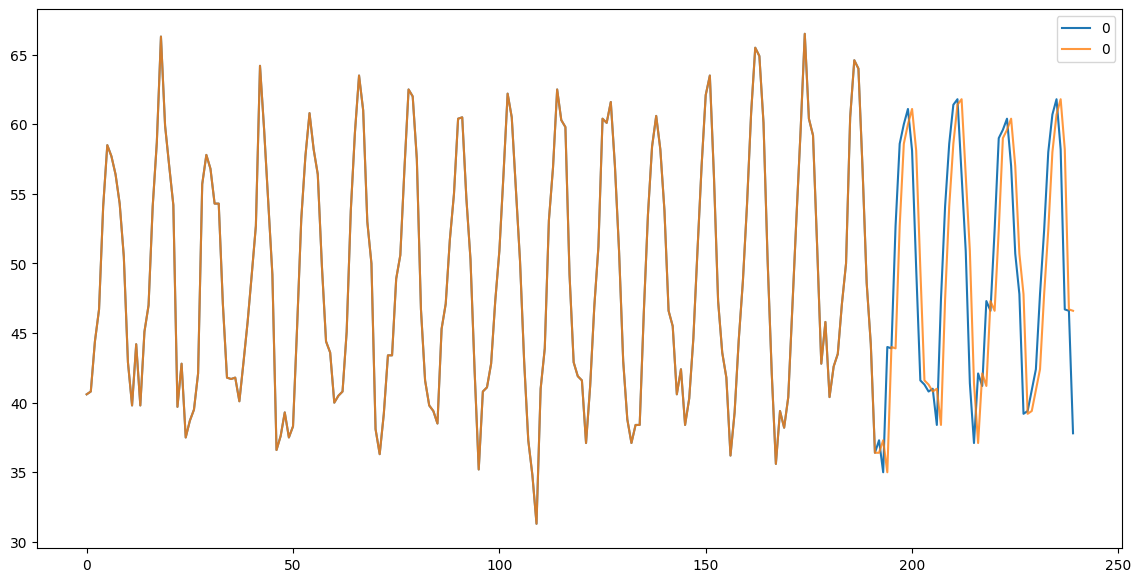

In [16]:
series = pd.read_csv('monthly-mean-temp.csv', header = 0, index_col = 0)
nombre = "temp"
encontrar_mejor_solucion(series, nombre, metodo = "promedio")


## 3. Sarima


In [ ]:
def prediccion_sarima(historia, config):
    orden, orden_estacional, tendencia = config
    # definir el modelo
    modelo = SARIMAX(historia, order = orden, seasonal_order = orden_estacional, trend = tendencia,
      enforce_stationarity = False, enforce_invertibility = False)
    # ajustar el model con los datos
    modelo_ajustado = modelo.fit(disp = False)
    # hacer la predicción de un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_sarima(estacional = [0]):
    modelos = []
    # definir las listas de configuración
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct'] 
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = estacional
    # crear instancias de configuración
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    modelos.append(cfg)
    return modelos

Tamaño Entrenamiento 192
Tamaño Prueba 48
Encontrando la mejor solución para sarima
else, datos, lista_cfg, n_prueba, metodo
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'n'] 50.042
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'c'] 8.366
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 't'] 25.947
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'ct'] 8.419
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'n'] 26.014
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'c'] 5.757
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 't'] 14.214
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'ct'] 5.799
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'n'] 17.091
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'c'] 4.718
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 't'] 10.390
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'ct'] 4.749
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'n'] 5.144
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'c'] 5.156
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 't'] 5.181
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'ct'] 5.196
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'n'] 4.912
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'c'] 4.924
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 't

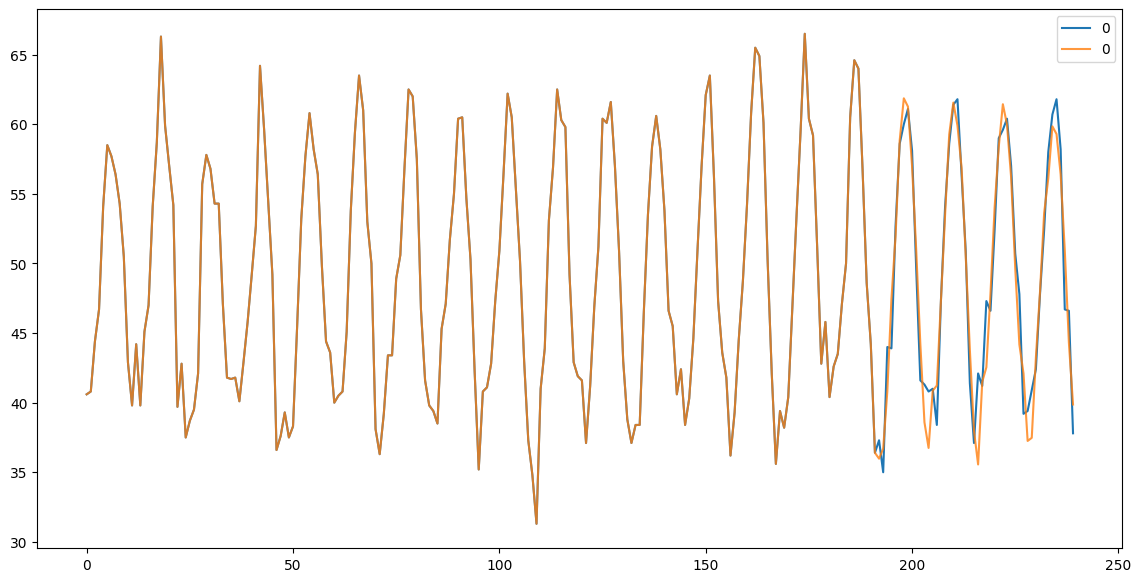

In [ ]:
series = pd.read_csv('monthly-mean-temp.csv', header = 0, index_col = 0)
nombre = "temp"
encontrar_mejor_solucion(series, nombre, metodo = "sarima")

## 4. Alisamiento exponencial

In [28]:
def prediccion_alisamiento_exp(historia, config):
    t, d, s, p, b, r = config
    # definir el modelo
    historia = array(historia)
    modelo = ExponentialSmoothing(historia, trend = t, damped = d, seasonal = s, 
                                  seasonal_periods = p)
    # ajustar el modelo con los datos
    modelo_ajustado = modelo.fit(optimized = True, use_boxcox = b, remove_bias = r)
    # predecir un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    print('yhat', yhat, historia, config)
    return yhat[0]

def config_alisamiento_exp(estacional = [None]): 
    modelos = []
    # definir las listas de config
    t_params = ['add', 'mul', None]
    d_params = [True, False] 
    s_params = ['add', 'mul', None]
    p_params = estacional
    b_params = [True, False]
    r_params = [True, False]
    # crear instancias de configuración
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            modelos.append(cfg)
    return modelos

In [50]:
series = pd.read_csv('monthly-mean-temp.csv', header = 0, index_col = 0)
nombre = "temp"
encontrar_mejor_solucion(series, nombre, metodo = "exp")

Tamaño Entrenamiento 192
Tamaño Prueba 48
Encontrando la mejor solución para exp
else, datos, lista_cfg, n_prueba, metodo
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaaaaaa None
Error None
aaa

IndexError: list index out of range